In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pi
import plotly.express as px
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta

In [2]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [3]:
stock_data = pd.read_csv('data1.csv')
stock_data.head()


,日期,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率,收益率,波动率
0,2004-02-04,9.88,10.01,10.08,9.85,193975,193900992.0,2.34,1.83,0.18,1.38,0.004983,0.022486
1,2004-02-05,10.06,10.06,10.28,9.98,174839,176604992.0,3.00,0.50,0.05,1.24,0.043760,0.023390
2,2004-02-06,10.08,10.51,10.98,9.88,438125,459816992.0,10.93,4.47,0.45,3.11,0.007583,0.021607
3,2004-02-09,10.54,10.59,10.74,10.42,196300,207036992.0,3.04,0.76,0.08,1.39,0.014065,0.021653
4,2004-02-10,10.65,10.74,10.95,10.51,232602,249108992.0,4.15,1.42,0.15,1.65,-0.011236,0.022132


In [4]:
#data overview
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4693 entries, 0 to 4692
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   日期      4693 non-null   object 
 1   开盘      4693 non-null   float64
 2   收盘      4693 non-null   float64
 3   最高      4693 non-null   float64
 4   最低      4693 non-null   float64
 5   成交量     4693 non-null   int64  
 6   成交额     4693 non-null   float64
 7   振幅      4693 non-null   float64
 8   涨跌幅     4693 non-null   float64
 9   涨跌额     4693 non-null   float64
 10  换手率     4693 non-null   float64
 11  收益率     4693 non-null   float64
 12  波动率     4693 non-null   float64
dtypes: float64(11), int64(1), object(1)
memory usage: 476.8+ KB


In [5]:
stock_data.describe().T

,count,mean,std,min,25%,50%,75%,max
开盘,4693.0,1.453420e+01,6.490971e+00,5.090000e+00,1.029000e+01,1.328000e+01,1.697000e+01,4.711000e+01
收盘,4693.0,1.454824e+01,6.489111e+00,5.100000e+00,1.029000e+01,1.329000e+01,1.698000e+01,4.805000e+01
最高,4693.0,1.479196e+01,6.665237e+00,5.230000e+00,1.041000e+01,1.350000e+01,1.724000e+01,4.898000e+01
最低,4693.0,1.430233e+01,6.322920e+00,5.050000e+00,1.017000e+01,1.308000e+01,1.668000e+01,4.701000e+01
成交量,4693.0,6.675073e+05,6.326273e+05,8.748000e+03,2.211390e+05,5.020870e+05,8.969010e+05,5.086050e+06
成交额,4693.0,9.625261e+08,9.449943e+08,6.962000e+06,3.357000e+08,6.932570e+08,1.283356e+09,8.596942e+09
振幅,4693.0,3.125250e+00,1.974286e+00,0.000000e+00,1.770000e+00,2.620000e+00,3.940000e+00,1.769000e+01
涨跌幅,4693.0,3.324952e-02,2.577503e+00,-4.189000e+01,-1.200000e+00,0.000000e+00,1.100000e+00,1.007000e+01
涨跌额,4693.0,-8.097166e-05,4.696381e-01,-8.060000e+00,-1.500000e-01,0.000000e+00,1.400000e-01,3.450000e+00
换手率,4693.0,9.193608e-01,8.069908e-01,6.000000e-02,4.100000e-01,6.400000e-01,1.160000e+00,8.400000e+00


In [6]:
stock_data.isna().sum()

日期     0
开盘     0
收盘     0
最高     0
最低     0
成交量    0
成交额    0
振幅     0
涨跌幅    0
涨跌额    0
换手率    0
收益率    0
波动率    0
dtype: int64

In [7]:
maxv=1.366039e-01
minv=2.271468e-03

In [8]:
stock_data['日期'] = pd.to_datetime(stock_data['日期'])
stock_data = stock_data.sort_values('日期')
stock = stock_data[['日期', '收盘', '最高', '最低', '开盘', '波动率','换手率','振幅']]
stock

,日期,收盘,最高,最低,开盘,波动率,换手率,振幅
0,2004-02-04,10.01,10.08,9.85,9.88,0.022486,1.38,2.34
1,2004-02-05,10.06,10.28,9.98,10.06,0.023390,1.24,3.00
2,2004-02-06,10.51,10.98,9.88,10.08,0.021607,3.11,10.93
3,2004-02-09,10.59,10.74,10.42,10.54,0.021653,1.39,3.04
4,2004-02-10,10.74,10.95,10.51,10.65,0.022132,1.65,4.15
...,...,...,...,...,...,...,...,...
4688,2023-12-22,9.20,9.28,9.11,9.19,0.010233,0.52,1.85
4689,2023-12-25,9.19,9.20,9.14,9.18,0.010361,0.21,0.65
4690,2023-12-26,9.10,9.20,9.07,9.19,0.009946,0.28,1.41
4691,2023-12-27,9.12,9.13,9.02,9.10,0.013541,0.33,1.21


In [9]:
#normalization
scaler = MinMaxScaler()
normalized_data = stock[['振幅', '最高', '换手率', '收盘', '波动率']].copy()#['开盘', '最高', '最低', '成交量', '收盘']
normalized_data = scaler.fit_transform(normalized_data)


In [10]:
train_data, test_data = train_test_split(normalized_data, test_size=0.2, shuffle=False)
train_df = pd.DataFrame(train_data, columns=['振幅', '最高', '换手率', '收盘', '波动率'])
test_df = pd.DataFrame(test_data, columns=['振幅', '最高', '换手率', '收盘', '波动率'])#['开盘', '最高', '最低', '成交量', '收盘']


In [11]:
#actual: seqlen-1
def generate_sequences(df, seq_length=27):
    X = df[['振幅', '最高', '换手率', '收盘', '波动率']].reset_index(drop=True)
    y = df[['振幅', '最高', '换手率', '收盘', '波动率']].reset_index(drop=True)

    sequences = []
    labels = []

    for index in range(len(X) - seq_length):
        sequences.append(X.iloc[index : index + seq_length].values)
        labels.append(y.iloc[index + seq_length ].values)

    sequences = np.array(sequences)
    labels = np.array(labels)

    return sequences, labels



In [12]:
train_sequences, train_labels = generate_sequences(train_df)
test_sequences, test_labels = generate_sequences(test_df)


In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Activation, Dropout

model = Sequential([
    LSTM(units=26, return_sequences=False, input_shape=(26, 5)),
    Dense(units = 5),
])

c:\Users\29950\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [14]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 26)             │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           135 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,463 (13.53 KB)

 Trainable params: 3,463 (13.53 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
epochs = 250
batch_size = 64

history = model.fit(
    train_sequences,
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_sequences, test_labels),
    verbose=1
)


Epoch 1/250


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0376 - mean_absolute_error: 0.1290 - val_loss: 0.0026 - val_mean_absolute_error: 0.0373
Epoch 2/250
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0051 - mean_absolute_error: 0.0457 - val_loss: 0.0019 - val_mean_absolute_error: 0.0299
Epoch 3/250
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0044 - mean_absolute_error: 0.0391 - val_loss: 0.0016 - val_mean_absolute_error: 0.0272
Epoch 4/250
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0037 - mean_absolute_error: 0.0360 - val_loss: 0.0015 - val_mean_absolute_error: 0.0259
Epoch 5/250
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0034 - mean_absolute_error: 0.0337 - val_loss: 0.0015 - val_mean_absolute_error: 0.0265
Epoch 6/250
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0034 - mean_absolute_error: 0.0335 - val_loss: 0.0014 - val_mean_absolute_error: 0.0229
Epoch 7/250
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0034 - mean_absolute_error: 0.0326 - val_loss: 0.0

In [16]:
train_predictions = model.predict(train_sequences)
test_predictions = model.predict(test_sequences)

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [17]:
fig = make_subplots(rows=1, cols=1, subplot_titles=('Close Predictions'))

train_close_pred = train_predictions[:, -1]
train_close_actual = train_labels[:, -1]

fig.add_trace(go.Scatter(x=np.arange(len(train_close_actual)), y=train_close_actual, mode='lines', name='Actual', opacity=0.9))
fig.add_trace(go.Scatter(x=np.arange(len(train_close_pred)), y=train_close_pred, mode='lines', name='Predicted', opacity=0.6))

fig.update_layout(title='波动率 Predictions on Train Data', template='plotly_dark')
fig.show()

In [18]:
fig = make_subplots(rows=1, cols=1, subplot_titles=('Close Predictions'))

test_close_pred = test_predictions[:, -1]
test_close_actual = test_labels[:, -1]

fig.add_trace(go.Scatter(x=np.arange(len(train_close_actual)), y=test_close_actual, mode='lines', name='Actual', opacity=0.9))
fig.add_trace(go.Scatter(x=np.arange(len(train_close_pred)), y=test_close_pred, mode='lines', name='Predicted', opacity=0.6))

fig.update_layout(title='波动率 Predictions on Test Data', template='plotly_dark')
fig.show()

In [19]:
sample=test_sequences[-1]
sample = np.expand_dims(sample, axis=0)
pred=model.predict(sample)

np.shape(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


(1, 27, 5)

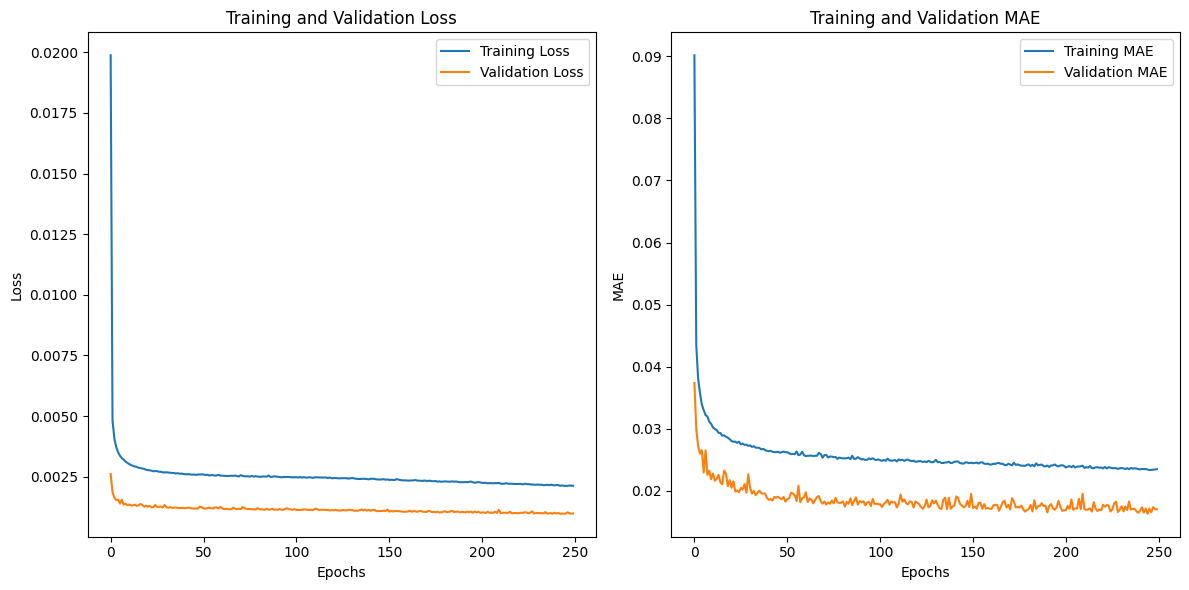

In [20]:
import matplotlib.pyplot as plt

# 获取训练过程中的损失值和MAE值
train_loss = history.history['loss']
train_mae = history.history['mean_absolute_error']

# 获取验证集上的损失值和MAE值
val_loss = history.history['val_loss']
val_mae = history.history['val_mean_absolute_error']

# 创建一个包含两个子图的图形
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 在第一个子图上绘制损失曲线
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# 在第二个子图上绘制MAE曲线
ax2.plot(train_mae, label='Training MAE')
ax2.plot(val_mae, label='Validation MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.set_title('Training and Validation MAE')
ax2.legend()

plt.tight_layout()  # 调整子图布局，防止重叠
plt.show()

In [21]:
import numpy as np

# 初始输入数据
input_data = np.expand_dims(test_sequences[-1], axis=0)  

# 循环预测未来十个时间步
predictions = []
for _ in range(11):
    # 进行预测
    prediction = model.predict(input_data)
    
    # 将预测值添加到predictions列表中
    predictions.append(prediction)
    
    # 更新输入数据，将新的预测值加入输入序列
    input_data = np.concatenate([input_data[:, 1:, :], np.expand_dims(prediction, axis=1)], axis=1)

# 将predictions列表转换为NumPy数组
predictions = np.array(predictions)

# 打印预测结果的形状
print(predictions.shape)  # 应该是 (11, 1, 5)，表示预测了11个时间步，每个时间步有一个样本，每个样本有5个预测值

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
(11, 1, 5)


In [22]:
predictions

array([[[0.12804191, 0.09212691, 0.05408385, 0.09375606, 0.08111549]],

       [[0.11374419, 0.09378229, 0.04592659, 0.09732215, 0.08016486]],

       [[0.10482937, 0.09500127, 0.03849609, 0.0992904 , 0.07900588]],

       [[0.09939849, 0.09656966, 0.03265676, 0.10082777, 0.07703891]],

       [[0.09550064, 0.09816714, 0.02805881, 0.10195352, 0.07461759]],

       [[0.0929698 , 0.09960818, 0.02439799, 0.10298643, 0.07201899]],

       [[0.09054678, 0.10088776, 0.02112399, 0.10389194, 0.0693735 ]],

       [[0.08965056, 0.10206581, 0.01833663, 0.10533302, 0.06676795]],

       [[0.08797936, 0.10331506, 0.01563002, 0.10657857, 0.06424843]],

       [[0.08636187, 0.10454718, 0.01299805, 0.10790236, 0.0617933 ]],

       [[0.08452095, 0.10579647, 0.01038409, 0.10924923, 0.05936119]]],
      dtype=float32)

In [23]:
future_predictions = predictions[:, :, -1]
future_predictions


array([[0.08111549],
       [0.08016486],
       [0.07900588],
       [0.07703891],
       [0.07461759],
       [0.07201899],
       [0.0693735 ],
       [0.06676795],
       [0.06424843],
       [0.0617933 ],
       [0.05936119]], dtype=float32)

In [24]:
#反归一化
future=[]
for i in future_predictions:
    temp = i*(maxv - minv) + minv
    future.append(temp)

future

[array([0.01316791], dtype=float32),
 array([0.01304021], dtype=float32),
 array([0.01288452], dtype=float32),
 array([0.01262029], dtype=float32),
 array([0.01229503], dtype=float32),
 array([0.01194595], dtype=float32),
 array([0.01159058], dtype=float32),
 array([0.01124057], dtype=float32),
 array([0.01090212], dtype=float32),
 array([0.01057231], dtype=float32),
 array([0.0102456], dtype=float32)]

In [25]:
future=future[1:]

In [26]:
latest_prediction = []
last_seq = test_sequences[:-1]

for _ in range(10):
    prediction = model.predict(last_seq)
    latest_prediction.append(prediction)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [27]:
np.shape(latest_prediction)

(10, 911, 5)

In [28]:
baseline=[0.01088023, 0.01088036, 0.01088036, 0.01088036, 0.01088036,
       0.01088036, 0.01088036, 0.01088036, 0.01088036, 0.01088036]

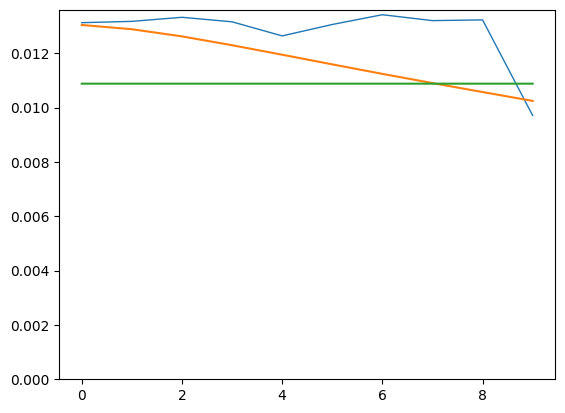

In [29]:
acdata = pd.read_csv('data333.csv')
acdata.tail(21)
acdatav=acdata.drop(acdata.tail(6).index)
acdatavv=acdatav.tail(10)
vdata=acdatavv['波动率'].tolist()
vdata1 = [element for element in vdata]  # 使用列表推导式将列列表转换为行列表
x=[]
for i in range(10):
    x.append(i)
plt.plot(x, vdata1,linewidth=1)
plt.plot(x,future)
plt.plot(x,baseline)
plt.ylim(0)


plt.show()

In [35]:
future

[array([0.01304021], dtype=float32),
 array([0.01288452], dtype=float32),
 array([0.01262029], dtype=float32),
 array([0.01229503], dtype=float32),
 array([0.01194595], dtype=float32),
 array([0.01159058], dtype=float32),
 array([0.01124057], dtype=float32),
 array([0.01090212], dtype=float32),
 array([0.01057231], dtype=float32),
 array([0.0102456], dtype=float32)]

In [36]:
model.save('baseline.h5')